##**Topic :** Maize leaf disease detection using VGG16 model and transfer learning procedure

###**Libraries**

In this section, we define important libraries to support our code and run without errors.

In [4]:
import os
import math
import glob
import random
import zipfile
import numpy as np
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tqdm import tqdm
from pathlib import Path
from sklearn import metrics
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras import layers
from matplotlib.image import imread
from matplotlib import pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from matplotlib.patches import FancyBboxPatch
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

After defining the libraries, we define a code to directly connect our drive directory to our work so that we have access to the necessary data important for to smootly train, validate it and test our data.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Kaggle Linkage**
In this section, we linked kaggle to our work environment to be able to directly download our dataset from the platform without importing it in our local machine.

In [6]:
os.environ["KAGGLE_USERNAME"] = "aubinerou@gmail.com"
os.environ["KAGGLE_KEY"] = "your_kaggle_api_key"

Below is the authentification code to retrieve data from kaggle platform

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
if api:
  print("Kaggle authentication successful!")
else:
  print('No connexion to the platform')

Kaggle authentication successful!


###**Data collection**
Linking the dataset platform to our pipeline help us to go through the data collection process where we explore [Kaggle.com](https://kaggle.com) platform to find and choose the dataset which meet the most our requirements. The dataset we choose is delivered by ***Smaranjit Ghose*** and is talking about maize leaves disease prediction. While exploring the platform, this below code help by zipping the dataset which allow us to download the dataset from the platform without any errors after that, we extract the folders from the ziped file. The dataset can be under this link [maize-leaf-disease-dataset](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset)

In [8]:
dataset = "smaranjitghose/corn-or-maize-leaf-disease-dataset"
download_path = "./maize-leaf-disease-dataset"
zip_file = os.path.join(download_path, dataset.split("/")[-1] + ".zip")

if not os.path.exists(download_path) or not any(os.scandir(download_path)):
    print("Downloading dataset from Kaggle...")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Dataset downloaded and extracted.")
else:
  print("Dataset already exists.")

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
Dataset downloaded and extracted.


After downloading the dataset kaggle platform, we import it to our workplace to easily access and interact with it.

In [16]:
dataset_path = '/content/maize-leaf-disease-dataset/data'

###**Distribution of the different classes in the dataset**

Importing the dataset to our workplace help us in developing a code to access the different element from the downloaded file.

In the below code, we first of all define a function which count all the classes from the dataset. After counting, we sort the result into descending order in such a way that when we will plot, we do not have any noises. while plotting the result, we make sure to clean the graph so that we have a clear view of what we need.

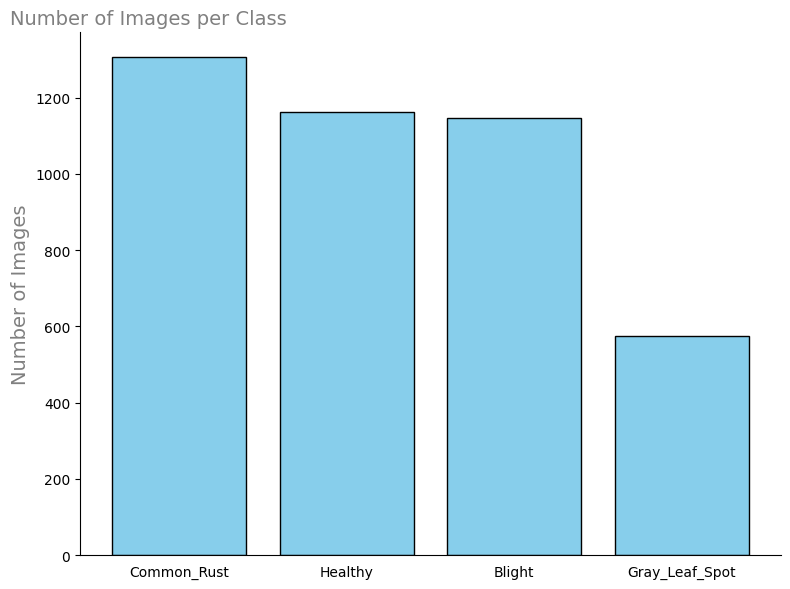

In [17]:
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Sort class_counts in descending order
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(8, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), color='skyblue', edgecolor='black')

plt.title('Number of Images per Class',x= -0.1, loc = 'left', color = 'gray', fontsize = 14)
plt.xlabel('')
plt.ylabel('Number of Images', color = 'gray', fontsize = 14)


plt.tick_params(axis='x', bottom=False, top=False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

**Result analysis:** The graph plotted show the distribution of images across classes. From this graph, we see that we have 4 classes such as: common_rust with the highest distribution followed by healthy and blight leaves. The lowest disease leaf is Gray Leaf Spot which is extremly low announcing a risk of imbalanced data.

Here we define some variables which are to be used as parameters as we go through the analysis.

In [20]:
batch_size = 64
img_h = 224
img_w = 224
seed = 200
n_classes = 4

###**Data preprocessing and data augmentation**
In this section, we normalise, split the data into training and testing set where 80% is for the train and the 20% left is for the validation set. A data augmentation has been applied on the training set which help to improve the model generalisation and at the same time a way to balance our dataset. The validation set on it side, has only rescale(normalise) without applying the data augmentation to it because validation data are to be unchanged. The result of this augmentation is to either change our images position, brightness, zooming and many more.

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    validation_split=0.2,
    fill_mode='nearest',
)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

###**Load dataset**

After splitting the data, we find a global set of around 4000+ entries with 4 classes. We assign 80% to the training set which is 3352 entries and 836 entries for the validation set everyone of them include all the 4 classes.

In [22]:
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='training'
)
val_generator = val_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='validation'
)


Found 3352 images belonging to 4 classes.
Found 836 images belonging to 4 classes.


We choose to evaluate our model on unseen data that is the reason why we search for a new dataset to carry that load.

In [23]:
test_path = '/content/drive/MyDrive/Dataset/testing_data'
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4800 images belonging to 4 classes.


While importing the dataset, we find that the dataset contains 4800 images distributed within 4 classes.

###**Plot a sample of data in the dataset**
The below code randomly generate 4 samples of data within the whole folder.

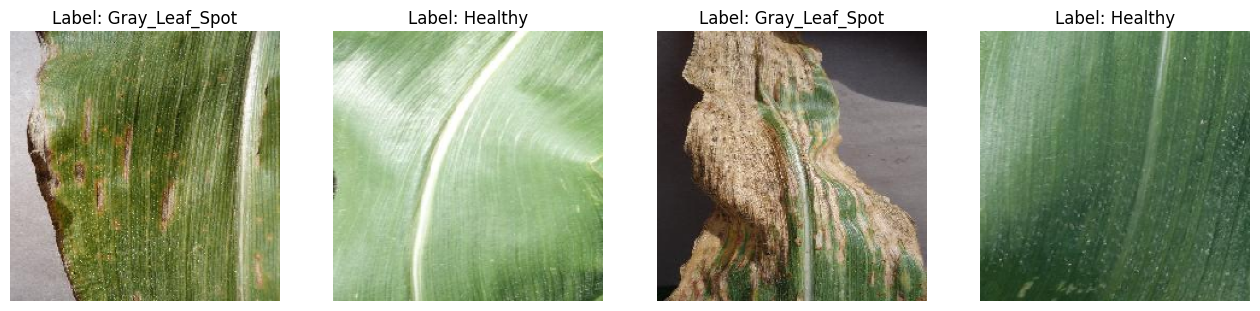

In [27]:
IMG_DIM = (img_h, img_w)
train_files = glob.glob('./maize-leaf-disease-dataset/data/*/*.*')
random.shuffle(train_files)
train_files = train_files[:4]

train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

fig, ax = plt.subplots(1, 4, figsize=(16, 6))

for i in range(len(train_imgs)):
    ax[i].imshow(train_imgs[i].astype('uint8'))
    ax[i].set_title(f'Label: {train_labels[i]}')
    ax[i].axis('off')

plt.show()

In the below code, we rewrite the augmentation technique so that we can plot it result. In that way, we use the sequential model to augment and generate more images after that, we plot the result of the augmented techniques which directly come from the previous plotting at index 0.

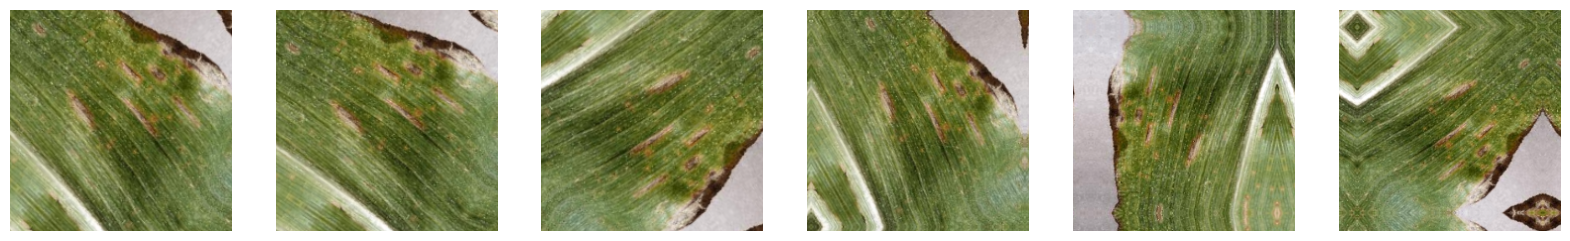

In [28]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.1),
])

plt.figure(figsize=(20, 6))
for i in range(6):
  augmented_image = data_augmentation(train_imgs)
  ax = plt.subplot(1, 6, i + 1)
  plt.imshow(augmented_image.numpy()[0].astype('uint8'))
  plt.axis("off")

plt.show()

###**VGG16 model loading**

To continue, we will use a pre-trained model (VGG16) which pre-trained model has to be loaded. After loading, we freeze the top layers to prevent it to change or update the weights of the convolutional layers during our model training. This pre-trained loaded will help us for transfer learning in our deep learning project.

In [29]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_h, img_w, 3))
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###**Model creation**

Here, we define our model architecture using transfer learning with VGG16 as the feature extractor. The convolutional feature maps are converted into a 1-D feature vector using GlobalAveragePooling2D (preferred over Flatten because it reduces the number of parameters and helps generalization). On top of this, we stack several fully connected layers with Batch Normalization and Dropout (20–30%) to stabilize training and reduce overfitting. Finally, we add a softmax layer for multi-class classification. We then display the model summary, which shows the layer structure, number of parameters, and the total trainable parameters.

In [30]:
model = Sequential([
    base_model,
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(n_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,626,244 (71.05 MB)

 Trainable params: 3,908,484 (14.91 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

**Model Architecture Explanation:** On top of the extracted features, we add a custom fully-connected classifier:
- Dense(1024) → BatchNorm → Dropout(0.3): captures high-level patterns while
  regularizing with BatchNorm and Dropout.
- Dense(512) → BatchNorm → Dropout(0.2): further abstraction with additional
  normalization and dropout for stability.
- Dense(256) → Dropout(0.2): smaller dense layer for dimensionality reduction
  and regularization.
- Dense(n_classes, softmax): final classification layer for our target classes.

This design allows us to leverage pretrained features (transfer learning) while
adapting the classifier to our specific dataset.
**Result analysis:** In conclusion, after running the code, we come out with a total parameters of 15m+. Within this, only 1m+ is training and the rest are non trainable parameters whihc is approximatively 14,717,760 meaning that all the non trainble parameters are frozen.

###**Model compilation**

In this section, we compile our model in Keras before training it. The model is compiled using the Adam optimizer function, which is necessary to adjust the define learning rates in a sens of improving the model convergence. For the loss function, we use categorical crossentropy, which is standard for multi-class classification tasks with one-hot encoded labels. To evaluate performance, we track both accuracy (the overall proportion of correct predictions) and precision (the proportion of correct positive predictions), giving us a clearer view of how well the model performs, especially in cases of class imbalance.

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision']
)

###**Callback function**

To improve our model efficiency and prevent overfitting(EarlyStopping), we use a callback function. Then, we save the best model (ModelCheckpoint), and dynamically adjusting learning rate (ReduceLROnPlateau) to ensure optimal convergence.

In [32]:
checkpoint_path = 'base_vgg16.keras'
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, min_delta=0.001),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

###**Fit and train the model**

Here, we train the model using the training dataset and evaluate it on a separate validation set at the end of each epoch. The training is performed for up to 50 epochs with callbacks to optimize learning. The training process optimizes the model while preventing overfitting.The history of training (loss, accuracy, and precision for both training and validation) is stored for later analysis and visualization.

In [94]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_list,
    epochs=60,
    verbose = 2
)

Epoch 1/60
52/52 - 55s - 1s/step - accuracy: 0.5152 - loss: 1.2981 - precision: 0.5587 - val_accuracy: 0.5877 - val_loss: 0.9391 - val_precision: 0.9837 - learning_rate: 1.0000e-04
Epoch 2/60
52/52 - 5s - 92ms/step - accuracy: 0.6719 - loss: 0.9176 - precision: 0.6949 - val_accuracy: 0.6022 - val_loss: 0.9326 - val_precision: 0.9876 - learning_rate: 1.0000e-04
Epoch 3/60
52/52 - 46s - 879ms/step - accuracy: 0.7147 - loss: 0.7957 - precision: 0.7433 - val_accuracy: 0.7776 - val_loss: 0.7173 - val_precision: 0.9761 - learning_rate: 1.0000e-04
Epoch 4/60
52/52 - 4s - 86ms/step - accuracy: 0.7188 - loss: 0.7904 - precision: 0.7333 - val_accuracy: 0.7692 - val_loss: 0.7234 - val_precision: 0.9653 - learning_rate: 1.0000e-04
Epoch 5/60
52/52 - 47s - 903ms/step - accuracy: 0.7689 - loss: 0.6216 - precision: 0.7891 - val_accuracy: 0.8630 - val_loss: 0.4866 - val_precision: 0.9627 - learning_rate: 1.0000e-04
Epoch 6/60
52/52 - 5s - 94ms/step - accuracy: 0.7500 - loss: 0.6255 - precision: 0.7869

**Overall Trend**

The model shows steady improvement in accuracy, precision, and validation performance during the first 35 epochs.

Training accuracy increased from 51.5% (Epoch 1) to 89.2% (Epoch 35).

Validation accuracy improved from 58.8% (Epoch 1) to 92.3% (Epoch 35).

**Loss Behavior**

Training loss dropped from 1.30 (Epoch 1) to 0.28 (Epoch 35), showing consistent convergence.

Validation loss reduced from 0.94 (Epoch 1) to 0.21 (Epoch 35), suggesting good generalization with limited overfitting so far.

**Precision Analysis**

Training precision improved from 0.56 → 0.90 across epochs.

Validation precision started very high (~0.98 in Epoch 1–2, likely due to class imbalance or conservative predictions), then stabilized in the 0.92–0.94 range from Epoch 10 onwards.

This indicates the model is predicting positive cases more reliably as it learns.

**Learning Rate Adjustments**

Initial learning rate was 1e-4 until Epoch 20, then reduced progressively to 5e-5 (Epochs 21–30) and 2.5e-5 (Epochs 31–35).

The reductions helped stabilize validation loss around 0.19–0.23, preventing divergence and overfitting.

**Potential Overfitting Signals**

From Epochs 27–32, validation accuracy plateaued around 90–91%, even while training accuracy improved.

However, after the learning rate decay, validation accuracy climbed again, reaching 92.3% by Epoch 35, suggesting the LR schedule is working well.

The moodel demonstrates strong learning capability with both training and validation accuracy exceeding 92% by Epoch 35.

- Loss curves indicate stable convergence with no severe overfitting so far.

- Learning rate scheduling is effective in maintaining generalization.

- Validation precision started unusually high in early epochs (possibly due to class imbalance) but later stabilized—worth monitoring further.

###**Plot loss curves and accuracy curves for training and validation sets**

To confirm our previous analysis, graphs have been plotted to visualise how the model taining and validation losses change over epochs and how the accuraccy of both training and validation also changes over epochs.

####**loss curves**

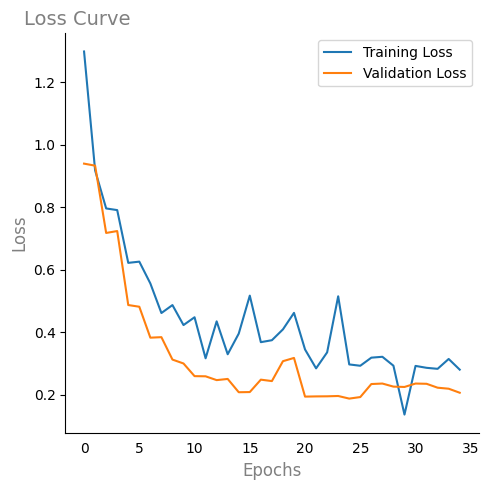

In [95]:
history = history
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', x= -0.1, loc = 'left', color = 'gray', fontsize = 14)
plt.xlabel('Epochs', color = 'gray', fontsize = 12)
plt.ylabel('Loss', color = 'gray', fontsize = 12)
plt.legend()

plt.tick_params(axis='x', bottom=False, top=False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()

plt.show()

* The training loss tarted high at 1.30 (Epoch 1), dropped quickly below 0.80 by Epoch 3–4, and reached ~0.28 by Epoch 35. This decline indicates consistent optimization progress.

* The validation loss began at 0.94, decreased steadily in the first 10 epochs (down to ~0.25), then stabilized in the 0.19–0.23 range by Epochs 20–35. Small fluctuations (slight rises around Epochs 19–20, 27–32) suggest normal variance but no strong divergence from training loss.

To summarise, both training and validation loss are decreasing in tandem. No major gap is observed, meaning overfitting is minimal at this stage.

####**Accuracy curves**

Here, we will display the Training Accuracy and Validation Accuracy curves, which is useful for assessing how well the model is learning

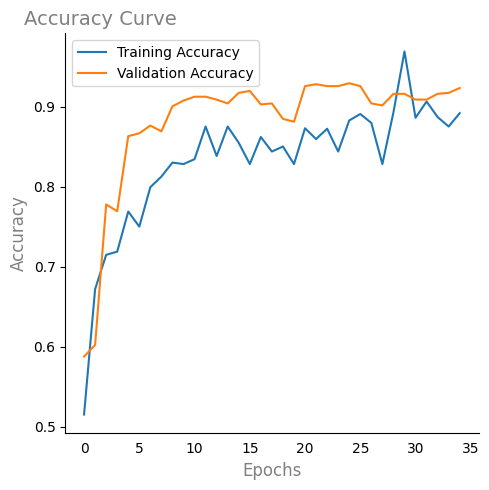

In [96]:
history = history
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', x= -0.1, loc = 'left', color = 'gray', fontsize = 14)
plt.xlabel('Epochs', color = 'gray', fontsize = 12)
plt.ylabel('Accuracy', color = 'gray', fontsize = 12)
plt.legend()

plt.tick_params(axis='x', bottom=False, top=False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()

plt.show()

* The training accuracy started at ~51% (Epoch 1), rose steadily past 70% by Epoch 4, and reached ~89% by Epoch 35. This increase suggest stable learning without sudden spikes.

* The validation began higher at ~59% (Epoch 1), improved sharply to 77–86% by Epoch 5–7, and then gradually climbed to ~92% by Epoch 35.

* Between Epochs 27–32, validation accuracy plateaued around 90%, while training accuracy continued increasing → mild overfitting risk, but this was mitigated after learning rate decay, pushing validation back up.

in summary, Accuracy curves show healthy convergence, with validation following training closely. The learning rate schedule helped avoid stagnation and sustained generalization.

In conclusion the accuracy curve shows a model that is learning, but the model is likely overfitting due to the rapid increasing performance it has within the first 15 epochs. Later on, it stabilises and allow our model to better generalize and learn better. Further process toward resolving that issue is necessary. The loss curve indicates stable convergence with validation loss flattening model has likely reached a near-optimal generalization zone. In total, their is no severe overfitting detected training and validation curves track closely.

**Overall, the analysis of both graphs confirm the analysis we have made within the our model training process. To increase our model performance, further actions are to be taken like fine tuning techniques.**



###**Model Fine-Tunning**


To increase and stabilize the performance of our model, a fine tuning process is necessary to transfer learning as it will use the base model performance and fixe the necessary issue within the model. This step will help to reinforce the model precision performance and further more the accuracy, the recall and the F1-score

####**Data collection**

To better evaluate our model, we collected another maize leaf disease data which come from Kaggle and can be found under this link [Fine_tunning dataset](https://www.kaggle.com/datasets/abdelrahmanemad2199/corn-or-maize-leaf-disease-dataset). It has been created by ***Abdelrahman Emad*** and has been updated 2 year ago. It comprised of apporximatively 12000 images all 4 classes included. To fine tune our model, the dataset has been divided into two one for the fine tuning process and the other one for the testing process to evaluate our model on unseen data.

In [33]:
dataset_fine_tune_path = '/content/drive/MyDrive/Dataset/tune_base_model'
train_fine_generator = train_datagen.flow_from_directory(
    directory=dataset_fine_tune_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=seed,
)
val_fine_generator = val_datagen.flow_from_directory(
    directory=dataset_fine_tune_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=seed,
)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In total, we assign 80% of the fine tuned data for the training process and 20% for the validation step which led to 4800 images for the training and 1200 images to validate our data

In the below code, we gradually unfreeze the base model starting from 'block3_conv1' onwards, all layers are set as trainable so the deeper convolutional blocks can be fine-tuned on our dataset. Earlier layers remain frozen to preserve low-level feature representations.

In [34]:
set_trainable = False
for layer in base_model.layers:
  if layer.name == "block3_conv1":
        set_trainable = True
  if layer.name == "block4_conv1":
        set_trainable = True
  if layer.name == "block5_conv1":
        set_trainable = True
  layer.trainable = set_trainable

###**Fine-tune model building**

Here, the model has been redeployed to see either the number of trainable parameters has increased or not

In [35]:
model_tune = Sequential([
    base_model,
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(n_classes, activation='softmax')
])
model_tune.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,626,244 (71.05 MB)

 Trainable params: 18,363,012 (70.05 MB)

 Non-trainable params: 263,232 (1.00 MB)

In total, the trainable parameters has increased from 1m+ to 15, 640, 068 trainable parameters.

In the below code, we adjust the learning rate from 1e-3 to 1e-6 (reducing to better appreciate our model performance)

In [36]:
model_tune.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy','precision']
)

In [37]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True, min_delta=0.001),
    ModelCheckpoint('fine_tunning_vgg16.keras', monitor='val_loss', save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8)
]

###**Model training**

In [127]:
fine_tune_model = model_tune.fit(
    train_fine_generator,
    steps_per_epoch= train_fine_generator.samples // batch_size,
    validation_data=val_fine_generator,
    validation_steps= val_fine_generator.samples // batch_size,
    epochs=60,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4978 - loss: 1.3933 - precision: 0.5370 - val_accuracy: 0.9688 - val_loss: 0.7469 - val_precision: 0.9979 - learning_rate: 1.0000e-05
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8833 - loss: 0.3465 - precision: 0.9055 - val_accuracy: 0.9887 - val_loss: 0.3349 - val_precision: 0.9981 - learning_rate: 1.0000e-05
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9404 - loss: 0.1842 - precision: 0.9502 - val_accuracy: 0.9905 - val_loss: 0.0927 - val_precision: 0.9948 - learning_rate: 1.0000e-05
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9521 - loss: 0.1424 - precision: 0.9618 - val_accuracy: 0.9922 - val_loss: 0.0374 - val_precision: 0.9939 - learning_rate: 1.0000e-05
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9714 - loss: 0.1095 - precision: 0.9725 - val_accuracy: 0.9948 - val_loss: 0.0236 - val_precision: 0.9965 - learning_rate: 1.0000e-05
Epoch 6/60

Training Accuracy:

Starts low at ~50% (Epoch 1) due to fine-tuning from pretrained weights.

Rapidly increases: 88% by Epoch 2, 95%+ by Epoch 4, and stabilizes around 98–99% by Epoch 10–21.

Curve shows very steep early growth, then a plateau — expected in fine-tuning.

Validation Accuracy:

Starts very high (97% in Epoch 1), indicating pretrained model already generalized well.

Peaks at ~99.6% (Epochs 8, 15, 20).

Small fluctuations between 98–99% suggest natural variance but no performance collapse.

👉 Takeaway: Accuracy curves converge quickly; validation tracks training extremely closely → fine-tuning is highly effective.

###**Plot loss curves for training and validation sets (fine tune model)**

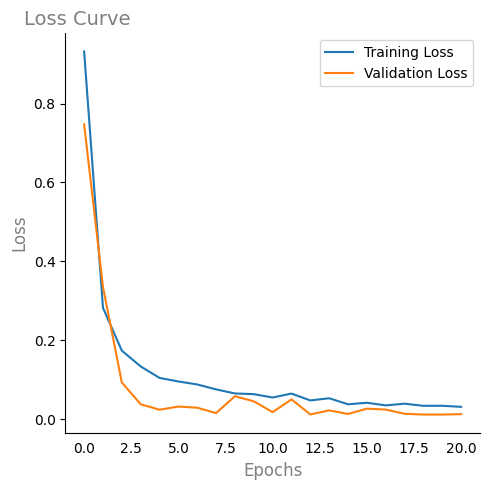

In [128]:
history = fine_tune_model
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve', x= -0.1, loc = 'left', color = 'gray', fontsize = 14)
plt.xlabel('Epochs', color = 'gray', fontsize = 12)
plt.ylabel('Loss', color = 'gray', fontsize = 12)
plt.legend()

plt.tick_params(axis='x', bottom=False, top=False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()

plt.show()

**Training Loss**

the training loss starts high at 1.39 (Epoch 1), drops sharply to 0.34 by Epoch 2 and 0.10 by Epoch 5. Falls below 0.05 after Epoch 11, reaching as low as 0.021 (Epoch 19).

**Validation Loss**
Begins at 0.75 (Epoch 1), decreases rapidly to 0.09 (Epoch 3), and further down to ~0.01–0.02 (Epochs 15–21). Minor oscillations (e.g., 0.05 at Epoch 12, 0.026 at Epoch 16) but overall stable and low, suggesting minimal overfitting.

**Loss curves show fast convergence with validation loss consistently following training giving a strong generalization.**

###**Plot accuracy curves for training and validation sets (fine tune model)**

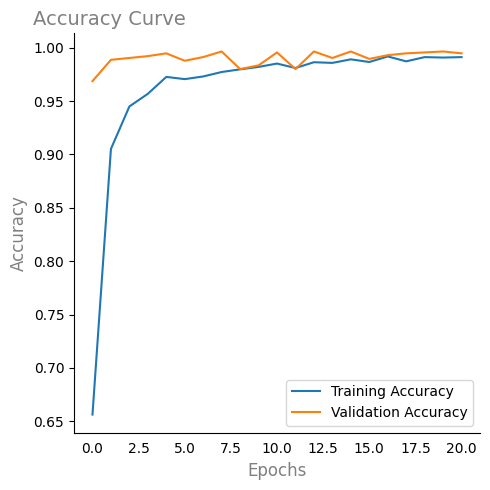

In [129]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve', x= -0.1, loc = 'left', color = 'gray', fontsize = 14)
plt.xlabel('Epochs', color = 'gray', fontsize = 12)
plt.ylabel('Accuracy', color = 'gray', fontsize = 12)
plt.legend()

plt.tick_params(axis='x', bottom=False, top=False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()

plt.show()

**Training Accuracy**
it starts low at ~50% (Epoch 1) due to fine-tuning from pretrained weights.
Rapidly increases: 88% by Epoch 2, 95%+ by Epoch 4, and stabilizes around 98–99% by Epoch 10–21. Curve shows very steep early growth, then a plateau — expected in fine-tuning.

**Validation Accuracy**
Starts very high (97% in Epoch 1), indicating pretrained model already generalized well.
Peaks at ~99.6% (Epochs 8, 15, 20). Small fluctuations between 98–99% suggest natural variance but no performance collapse.

**Accuracy curves converge quickly; validation tracks training extremely closely. fine-tuning is highly effective.**

**In general the fine-tuned model converged rapidly, achieving ~99% accuracy and ~0.01–0.02 validation loss within 20 epochs. Both curves show stability with minimal overfitting, indicating excellent generalization.**

###**Evaluate both models on test data**

This section will take in count both models (the model itself and the fine tunned model) to evaluate them efficiently. here are some key take away:
- Load saved models
- Load test images
- Make predictions for both models
- Convert predictions to class labels
- Print classification report for both models
- Make a visual test

In [145]:
extract_feat_model = tf.keras.models.load_model('base_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('fine_tunning_vgg16.keras')

predictions_extract_feat_model = np.argmax(extract_feat_model.predict(test_generator, verbose=0), axis=1)
predictions_fine_tune_model = np.argmax(fine_tune_model.predict(test_generator, verbose=0), axis=1)

# Get the true labels from the test_generator
test_labels_enc = test_generator.classes

# Encoding functions (already defined in previous cells)
class2num = {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
num2class = {0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

# Convert numeric predictions to class labels
predictions_extract_feat_model_class = [num2class[x] for x in predictions_extract_feat_model]
predictions_fine_tune_model_class = [num2class[x] for x in predictions_fine_tune_model]

# Print classification report for both models
print('Base Model')
print(metrics.classification_report(test_labels_enc, predictions_extract_feat_model, target_names=num2class.values()))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels_enc, predictions_fine_tune_model, target_names=num2class.values()))

# Plot an image with title (reusing the function defined later for consistency)
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image.astype('uint8'))
    plt.title(f"Model: {model_name}\nActual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

Base Model
                precision    recall  f1-score   support

        Blight       0.79      0.93      0.85      1200
   Common_Rust       0.86      1.00      0.93      1200
Gray_Leaf_Spot       0.90      0.58      0.70      1200
       Healthy       0.98      0.99      0.98      1200

      accuracy                           0.87      4800
     macro avg       0.88      0.87      0.87      4800
  weighted avg       0.88      0.87      0.87      4800

Fine-Tuned Model
                precision    recall  f1-score   support

        Blight       0.98      0.98      0.98      1200
   Common_Rust       1.00      1.00      1.00      1200
Gray_Leaf_Spot       0.98      0.98      0.98      1200
       Healthy       1.00      1.00      1.00      1200

      accuracy                           0.99      4800
     macro avg       0.99      0.99      0.99      4800
  weighted avg       0.99      0.99      0.99      4800



In summary both models performs very well with an accuracy of up to 87% for the base model and 99% for the fine tunned model also the model is precise while generating output and barely has errors. The accuraccy metrics comparaison shows that the fine tuning model performs better than the base model either in precision, recall or f1-score.

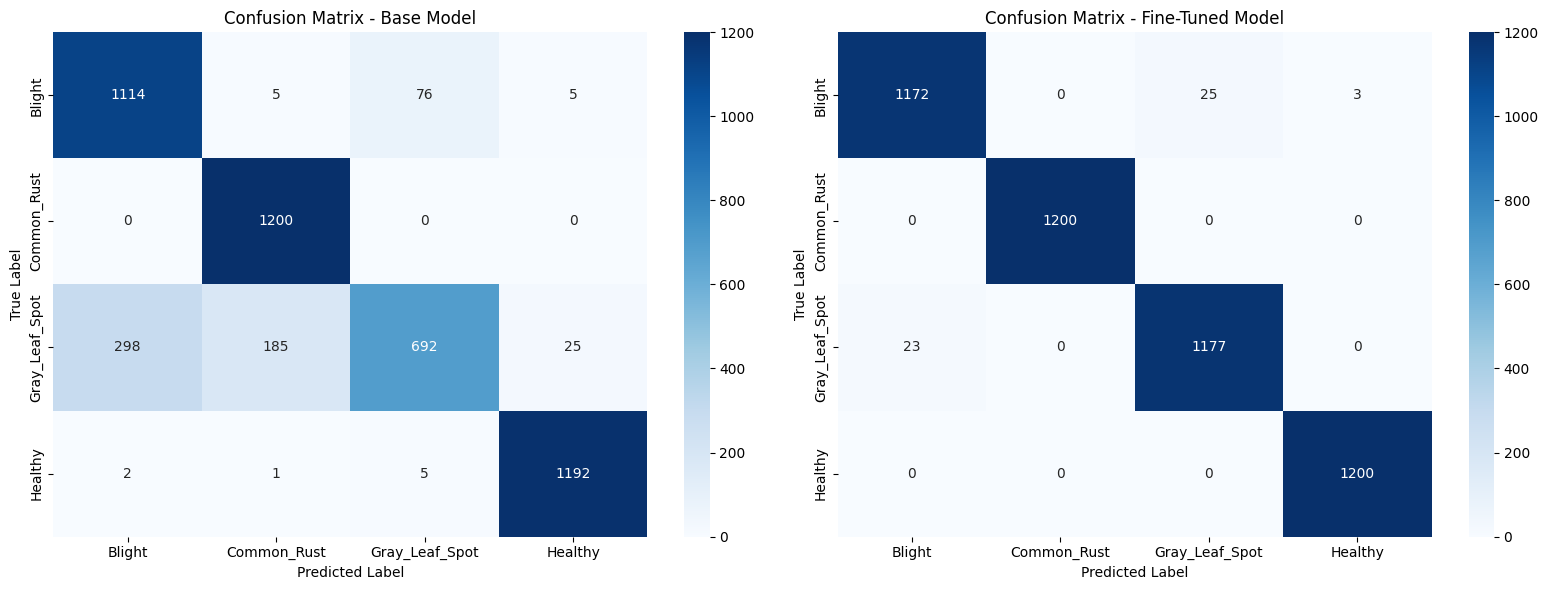

In [158]:
test_files_bl = glob.glob('/content/drive/MyDrive/Dataset/testing_data/Blight/*')
test_files_cr = glob.glob('/content/drive/MyDrive/Dataset/testing_data/Common_Rust/*')
test_files_gls = glob.glob('/content/drive/MyDrive/Dataset/testing_data/Gray_Leaf_Spot/*')
test_files_health = glob.glob('/content/drive/MyDrive/Dataset/testing_data/Healthy/*')
test_files = test_files_bl + test_files_cr + test_files_gls + test_files_health

test_imgs = [
    tf.keras.preprocessing.image.img_to_array(
        tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)
    ) for img in test_files
]
test_imgs = np.array(test_imgs)

test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize images
IMG_DIM = (224, 224)
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Encoding functions
class2num = {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
num2class = {0: 'Blight', 1: 'Common_Rust', 2: 'Gray_Leaf_Spot', 3: 'Healthy'}

# Convert test labels to numeric
test_labels_enc = [class2num[label] for label in test_labels]

# Make predictions for both models
predictions_extract_feat_model = np.argmax(extract_feat_model.predict(test_imgs_scaled, verbose=0), axis=1)
predictions_fine_tune_model = np.argmax(fine_tune_model.predict(test_imgs_scaled, verbose=0), axis=1)

# Confusion matrices
cm_extract_feat = confusion_matrix(test_labels_enc, predictions_extract_feat_model)
cm_fine_tune = confusion_matrix(test_labels_enc, predictions_fine_tune_model)

# Create subplots (1 row, 2 columns) to show both confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extract Features Model Confusion Matrix
sns.heatmap(cm_extract_feat, annot=True, fmt='d', cmap='Blues',
            xticklabels=num2class.values(), yticklabels=num2class.values(), ax=ax1)
ax1.set_title('Confusion Matrix - Base Model')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# Fine-Tuned Model Confusion Matrix
sns.heatmap(cm_fine_tune, annot=True, fmt='d', cmap='Blues',
            xticklabels=num2class.values(), yticklabels=num2class.values(), ax=ax2)
ax2.set_title('Confusion Matrix - Fine-Tuned Model')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

The analysis of both confusion metrix shows that the base model correctly predicted common rust disease.Apart from that, it predicted the blight, gray leaf spot and healthy leaf wiht important misclassification and this misclassification is more important when we come to gray leaf spot where 298 were confuse with blight and 185 confuse as common. Taking the fine tuning, the model correctly predicted the common rust and the healthy leaf without any misclassification when it common to blight and gray leaf spot, they make some mistake but not important mistake. blight over 1200 images tested confused 25 with gray leaf spot and 3 with healthy leaf and gray leaf spot over 1200 confused 23 with blight disease.
In summary, we can say that the fine tuning help in enhance our model performance

###**Plot a test image using Extract Features Model**
Here we make predictions to see how our model performs

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step
Image 1075: True: Blight, Predicted: Blight (100.00%)
Image 3154: True: Gray_Leaf_Spot, Predicted: Gray_Leaf_Spot (100.00%)
Image 4182: True: Healthy, Predicted: Healthy (100.00%)
Image 2342: True: Common_Rust, Predicted: Common_Rust (100.00%)
Image 2216: True: Common_Rust, Predicted: Common_Rust (100.00%)
Image 2078: True: Common_Rust, Predicted: Common_Rust (100.00%)
Image 3962: True: Healthy, Predicted: Healthy (99.88%)
Image 774: True: Blight, Predicted: Blight (100.00%)
Image 1264: True: Common_Rust, Predicted: Common_Rust (100.00%)
Image 1674: True: Common_Rust, Predicted: Common_Rust (100.00%)


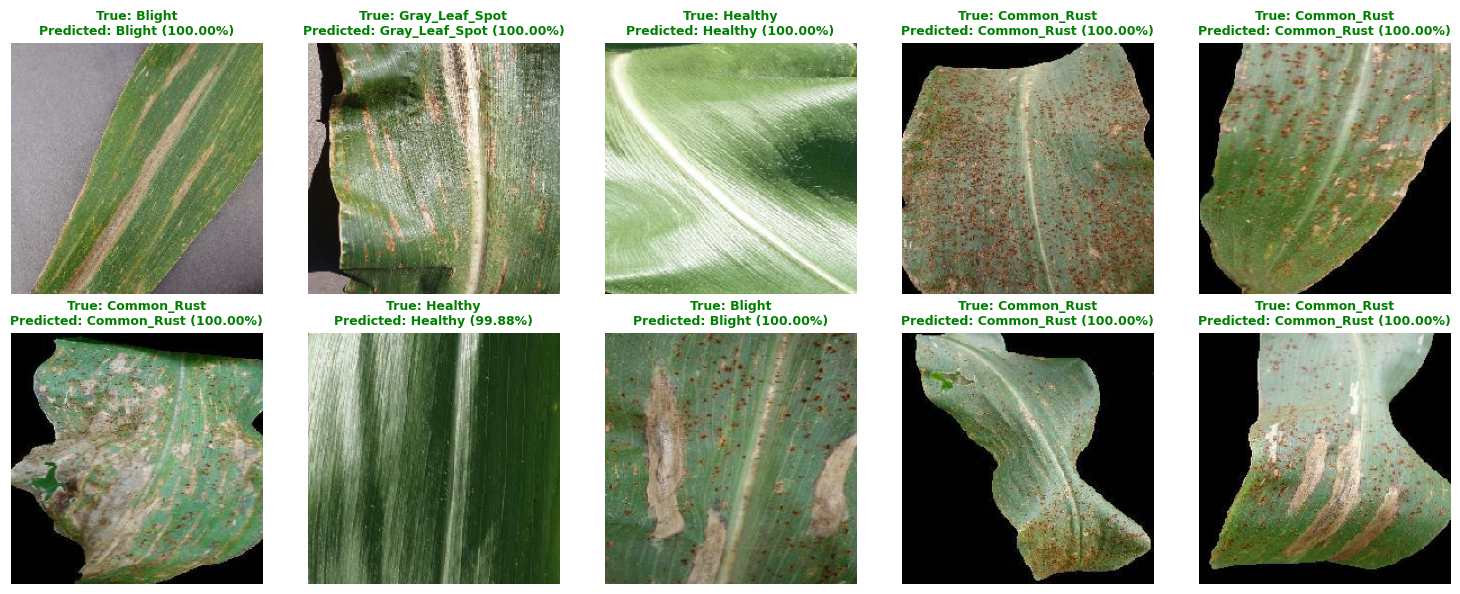

In [161]:
model = load_model("fine_tunning_vgg16.keras")

# Predict probabilities for all test images
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # class indices
class_labels = list(test_generator.class_indices.keys())
true_labels = test_generator.classes

# Select 20 random indices from the test set (reverting to random sampling)
display_indices = random.sample(range(len(test_generator.filenames)), 10)

# Determine the number of rows needed
n_cols = 5
n_rows = (len(display_indices) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3)) # Adjusted figure size
axes = axes.flatten() # Flatten the axes array for easy iteration

# Example: show the selected predictions
for idx, i in enumerate(display_indices):
    # Get the image path and load the image
    img_path = test_generator.filepaths[i]
    img_to_show = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_to_show = tf.keras.preprocessing.image.img_to_array(img_to_show)

    # Get the true label
    true_label = class_labels[test_generator.classes[i]]

    # Get the predicted label and its probability
    predicted_label = class_labels[y_pred_classes[i]]
    predicted_probability = y_pred_prob[i, y_pred_classes[i]] * 100 # Probability as percentage

    # Determine color based on correctness
    label_color = 'green' if true_label == predicted_label else 'red'

    print(f"Image {i+1}: True: {true_label}, Predicted: {predicted_label} ({predicted_probability:.2f}%)")

    # Plot the image in the current subplot
    axes[idx].imshow(img_to_show.astype('uint8'))
    title_text = f"True: {true_label}\nPredicted: {predicted_label} ({predicted_probability:.2f}%)"
    axes[idx].set_title(title_text, fontsize=9, fontweight='bold', color=label_color)

    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In total, I runed this particular cells more than 30 times but I usually get good precision the miclassification which occurs over the 30 are 2 and generally occurs within the blight disease.

###**VGG16 model Architecture**

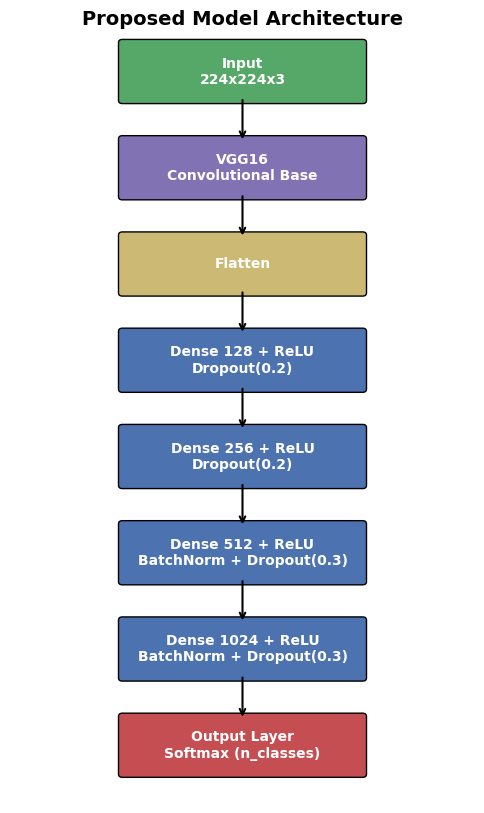

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def draw_block(ax, text, xy, width=2.8, height=0.8, color="#4C72B0"):
    x, y = xy
    box = FancyBboxPatch((x, y), width, height,
                         boxstyle="round,pad=0.1,rounding_size=0.05",
                         linewidth=1, edgecolor="black", facecolor=color)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha="center", va="center",
            fontsize=10, color="white", weight="bold")
    return x, y, width, height


fig, ax = plt.subplots(figsize=(6, 10))
ax.set_xlim(0, 6)
ax.set_ylim(0, 12)
ax.axis("off")


layers = [
    ("Input\n224x224x3", "#55A868"),
    ("VGG16\nConvolutional Base", "#8172B3"),
    ("Flatten", "#CCB974"),
    ("Dense 128 + ReLU\nDropout(0.2)", "#4C72B0"),
    ("Dense 256 + ReLU\nDropout(0.2)", "#4C72B0"),
    ("Dense 512 + ReLU\nBatchNorm + Dropout(0.3)", "#4C72B0"),
    ("Dense 1024 + ReLU\nBatchNorm + Dropout(0.3)", "#4C72B0"),
    ("Output Layer\nSoftmax (n_classes)", "#C44E52"),
]


y_pos = 11
boxes = []
for text, color in layers:
    box_dims = draw_block(ax, text, (1.5, y_pos), width=3.0, height=0.8, color=color)
    boxes.append(box_dims)
    y_pos -= 1.5


for i in range(len(boxes)-1):
    x, y, w, h = boxes[i]
    x_next, y_next, w_next, h_next = boxes[i+1]


    ax.annotate("",
                xy=(x_next + w_next/2, y_next + h_next),
                xytext=(x + w/2, y),
                arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

plt.title("Proposed Model Architecture", fontsize=14, weight="bold")
plt.show()

In [182]:
model = load_model("fine_tunning_vgg16.keras")

loss, accuracy, precision = model.evaluate(test_generator)
precision = round(precision, 2)
accuracy = round(accuracy, 2)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Overall Precision: {precision*100:.2f}%")
print(f"Overall Loss: {loss:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.9855 - loss: 0.0529 - precision: 0.9862
Overall Accuracy: 99.00%
Overall Precision: 99.00%
Overall Loss: 0.0402


**General conclusion** : In summary, we use a dataset collected from a known platform (Kaggle) to condut our research. During the process, we use a pre-trained model to assist us in our model training (tranfer learning) which backbone model is VGG16. After defining our new model, we train it with at least 60 epochs which doen't run till the end before stopping the process because their is a timer and learning rate function to regulate the training process. After that, we plot and fine tune our model. While evaluating the model, we find out that the base model perform less than the fine tune model with an accuracy of 99% including the precission; recall and F1-score for each diseases. 10 predictions have been plotted using the fine tune model on a defined dataset which were not seeing during the training and the fine tuning process and overall the predictions were very good compare to the base model.